# Lab 5: Logistic Classification

Author: Seungjae Lee (이승재)

<div class="alert alert-warning">
    We use elemental PyTorch to implement linear regression here. However, in most actual applications, abstractions such as <code>nn.Module</code> or <code>nn.Linear</code> are used. You can see those implementations near the end of this notebook.
</div>

## Reminder: Logistic Regression

### Hypothesis

$$ H(X) = \frac{1}{1+e^{-W^T X}} $$

### Cost

$$ cost(W) = -\frac{1}{m} \sum y \log\left(H(x)\right) + (1-y) \left( \log(1-H(x) \right) $$

 - If $y \simeq H(x)$, cost is near 0.
 - If $y \neq H(x)$, cost is high.

### Weight Update via Gradient Descent

$$ W := W - \alpha \frac{\partial}{\partial W} cost(W) $$

 - $\alpha$: Learning rate

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# For reproducibility
torch.manual_seed(1)

## Training Data

In [3]:
x_data = [[1, 2], [2, 3], [3, 1], [4, 3], [5, 3], [6, 2]]
y_data = [[0], [0], [0], [1], [1], [1]]

Consider the following classification problem: given the number of hours each student spent watching the lecture and working in the code lab, predict whether the student passed or failed a course. For example, the first (index 0) student watched the lecture for 1 hour and spent 2 hours in the lab session ([1, 2]), and ended up failing the course ([0]).

In [30]:
y_data==0

False

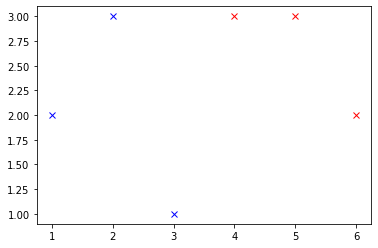

In [35]:
import numpy as np
import matplotlib.pyplot as plt
plt.plot(np.array(x_data)[0:3,0], np.array(x_data)[0:3,1], 'bx')
plt.plot(np.array(x_data)[3:,0], np.array(x_data)[3:,1], 'rx')
plt.show()

In [36]:
x_train = torch.FloatTensor(x_data)
y_train = torch.FloatTensor(y_data)

As always, we need these data to be in `torch.Tensor` format, so we convert them.

In [37]:
print(x_train.shape)
print(y_train.shape)

torch.Size([6, 2])
torch.Size([6, 1])


## Computing the Hypothesis

$$ H(X) = \frac{1}{1+e^{-W^T X}} $$

PyTorch has a `torch.exp()` function that resembles the exponential function.

In [38]:
print('e^1 equals: ', torch.exp(torch.FloatTensor([1])))

e^1 equals:  tensor([2.7183])


We can use it to compute the hypothesis function conveniently.

In [39]:
W = torch.zeros((2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [40]:
hypothesis = 1 / (1 + torch.exp(-(x_train.matmul(W) + b)))

In [41]:
print(hypothesis)
print(hypothesis.shape)

tensor([[0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000]], grad_fn=<MulBackward0>)
torch.Size([6, 1])


Or, we could use `torch.sigmoid()` function! This resembles the sigmoid function:

In [42]:
print('1/(1+e^{-1}) equals: ', torch.sigmoid(torch.FloatTensor([1])))

1/(1+e^{-1}) equals:  tensor([0.7311])


Now, the code for hypothesis function is cleaner.

In [43]:
hypothesis = torch.sigmoid(x_train.matmul(W) + b)

In [44]:
print(hypothesis)
print(hypothesis.shape)

tensor([[0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000]], grad_fn=<SigmoidBackward>)
torch.Size([6, 1])


## Computing the Cost Function (Low-level)

$$ cost(W) = -\frac{1}{m} \sum y \log\left(H(x)\right) + (1-y) \left( \log(1-H(x) \right) $$

We want to measure the difference between `hypothesis` and `y_train`.

In [45]:
print(hypothesis)
print(y_train)

tensor([[0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000]], grad_fn=<SigmoidBackward>)
tensor([[0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.]])


For one element, the loss can be computed as follows:

In [46]:
-(y_train[0] * torch.log(hypothesis[0]) + 
  (1 - y_train[0]) * torch.log(1 - hypothesis[0]))

tensor([0.6931], grad_fn=<NegBackward>)

To compute the losses for the entire batch, we can simply input the entire vector.

In [47]:
losses = -(y_train * torch.log(hypothesis) + 
           (1 - y_train) * torch.log(1 - hypothesis))
print(losses)

tensor([[0.6931],
        [0.6931],
        [0.6931],
        [0.6931],
        [0.6931],
        [0.6931]], grad_fn=<NegBackward>)


Then, we just `.mean()` to take the mean of these individual losses.

In [48]:
cost = losses.mean()
print(cost)

tensor(0.6931, grad_fn=<MeanBackward0>)


## Computing the Cost Function with `F.binary_cross_entropy`

In reality, binary classification is used so often that PyTorch has a simple function called `F.binary_cross_entropy` implemented to lighten the burden.

In [49]:
F.binary_cross_entropy(hypothesis, y_train)

tensor(0.6931, grad_fn=<BinaryCrossEntropyBackward>)

## Training with Low-level Binary Cross Entropy Loss

In [50]:
x_data = [[1, 2], [2, 3], [3, 1], [4, 3], [5, 3], [6, 2]]
y_data = [[0], [0], [0], [1], [1], [1]]
x_train = torch.FloatTensor(x_data)
y_train = torch.FloatTensor(y_data)

In [51]:
# 모델 초기화
W = torch.zeros((2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
# optimizer 설정
optimizer = optim.SGD([W, b], lr=1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # Cost 계산
    hypothesis = torch.sigmoid(x_train.matmul(W) + b) # or .mm or @
    cost = -(y_train * torch.log(hypothesis) + 
             (1 - y_train) * torch.log(1 - hypothesis)).mean()

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 100번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/1000 Cost: 0.693147
Epoch  100/1000 Cost: 0.134722
Epoch  200/1000 Cost: 0.080643
Epoch  300/1000 Cost: 0.057900
Epoch  400/1000 Cost: 0.045300
Epoch  500/1000 Cost: 0.037261
Epoch  600/1000 Cost: 0.031673
Epoch  700/1000 Cost: 0.027556
Epoch  800/1000 Cost: 0.024394
Epoch  900/1000 Cost: 0.021888
Epoch 1000/1000 Cost: 0.019852


## Training with `F.binary_cross_entropy`

In [52]:
# 모델 초기화
W = torch.zeros((2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
# optimizer 설정
optimizer = optim.SGD([W, b], lr=1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # Cost 계산
    hypothesis = torch.sigmoid(x_train.matmul(W) + b) # or .mm or @
    cost = F.binary_cross_entropy(hypothesis, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 100번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/1000 Cost: 0.693147
Epoch  100/1000 Cost: 0.134722
Epoch  200/1000 Cost: 0.080643
Epoch  300/1000 Cost: 0.057900
Epoch  400/1000 Cost: 0.045300
Epoch  500/1000 Cost: 0.037261
Epoch  600/1000 Cost: 0.031672
Epoch  700/1000 Cost: 0.027556
Epoch  800/1000 Cost: 0.024394
Epoch  900/1000 Cost: 0.021888
Epoch 1000/1000 Cost: 0.019852


## Loading Real Data

In [53]:
import numpy as np

In [54]:
xy = np.loadtxt('data-03-diabetes.csv', delimiter=',', dtype=np.float32)
x_data = xy[:, 0:-1]
y_data = xy[:, [-1]]
x_train = torch.FloatTensor(x_data)
y_train = torch.FloatTensor(y_data)

In [55]:
print(x_train[0:5])
print(y_train[0:5])

tensor([[-0.2941,  0.4874,  0.1803, -0.2929,  0.0000,  0.0015, -0.5312, -0.0333],
        [-0.8824, -0.1457,  0.0820, -0.4141,  0.0000, -0.2072, -0.7669, -0.6667],
        [-0.0588,  0.8392,  0.0492,  0.0000,  0.0000, -0.3055, -0.4927, -0.6333],
        [-0.8824, -0.1055,  0.0820, -0.5354, -0.7778, -0.1624, -0.9240,  0.0000],
        [ 0.0000,  0.3769, -0.3443, -0.2929, -0.6028,  0.2846,  0.8873, -0.6000]])
tensor([[0.],
        [1.],
        [0.],
        [1.],
        [0.]])


## Training with Real Data using low-level Binary Cross Entropy Loss

In [56]:
# 모델 초기화
W = torch.zeros((8, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
# optimizer 설정
optimizer = optim.SGD([W, b], lr=1)

nb_epochs = 100
for epoch in range(nb_epochs + 1):

    # Cost 계산
    hypothesis = torch.sigmoid(x_train.matmul(W) + b) # or .mm or @
    cost = -(y_train * torch.log(hypothesis) + (1 - y_train) * torch.log(1 - hypothesis)).mean()

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 10번마다 로그 출력
    if epoch % 10 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/100 Cost: 0.693148
Epoch   10/100 Cost: 0.572727
Epoch   20/100 Cost: 0.539493
Epoch   30/100 Cost: 0.519708
Epoch   40/100 Cost: 0.507066
Epoch   50/100 Cost: 0.498539
Epoch   60/100 Cost: 0.492549
Epoch   70/100 Cost: 0.488208
Epoch   80/100 Cost: 0.484985
Epoch   90/100 Cost: 0.482543
Epoch  100/100 Cost: 0.480661


## Training with Real Data using `F.binary_cross_entropy`

In [57]:
# 모델 초기화
W = torch.zeros((8, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
# optimizer 설정
optimizer = optim.SGD([W, b], lr=1)

nb_epochs = 100
for epoch in range(nb_epochs + 1):

    # Cost 계산
    hypothesis = torch.sigmoid(x_train.matmul(W) + b) # or .mm or @
    cost = F.binary_cross_entropy(hypothesis, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 10번마다 로그 출력
    if epoch % 10 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/100 Cost: 0.693147
Epoch   10/100 Cost: 0.572727
Epoch   20/100 Cost: 0.539494
Epoch   30/100 Cost: 0.519708
Epoch   40/100 Cost: 0.507065
Epoch   50/100 Cost: 0.498539
Epoch   60/100 Cost: 0.492549
Epoch   70/100 Cost: 0.488208
Epoch   80/100 Cost: 0.484985
Epoch   90/100 Cost: 0.482543
Epoch  100/100 Cost: 0.480661


## Checking the Accuracy our our Model

After we finish training the model, we want to check how well our model fits the training set.

In [58]:
hypothesis = torch.sigmoid(x_train.matmul(W) + b)
print(hypothesis[:5])

tensor([[0.4103],
        [0.9242],
        [0.2300],
        [0.9411],
        [0.1772]], grad_fn=<SliceBackward>)


We can change **hypothesis** (real number from 0 to 1) to **binary predictions** (either 0 or 1) by comparing them to 0.5.

In [59]:
prediction = hypothesis >= torch.FloatTensor([0.5])
print(prediction[:5])

tensor([[False],
        [ True],
        [False],
        [ True],
        [False]])


Then, we compare it with the correct labels `y_train`.

In [60]:
print(prediction[:5])
print(y_train[:5])

tensor([[False],
        [ True],
        [False],
        [ True],
        [False]])
tensor([[0.],
        [1.],
        [0.],
        [1.],
        [0.]])


In [61]:
correct_prediction = prediction.float() == y_train
print(correct_prediction[:5])

tensor([[True],
        [True],
        [True],
        [True],
        [True]])


Finally, we can calculate the accuracy by counting the number of correct predictions and dividng by total number of predictions.

In [62]:
accuracy = correct_prediction.sum().item() / len(correct_prediction)
print('The model has an accuracy of {:2.2f}% for the training set.'.format(accuracy * 100))

The model has an accuracy of 76.68% for the training set.


## Optional: High-level Implementation with `nn.Module`

In [63]:
class BinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(8, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.linear(x))

In [64]:
model = BinaryClassifier()

In [65]:
# optimizer 설정
optimizer = optim.SGD(model.parameters(), lr=1)

nb_epochs = 100
for epoch in range(nb_epochs + 1):

    # H(x) 계산
    hypothesis = model(x_train)

    # cost 계산
    cost = F.binary_cross_entropy(hypothesis, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    # 20번마다 로그 출력
    if epoch % 10 == 0:
        prediction = hypothesis >= torch.FloatTensor([0.5])
        correct_prediction = prediction.float() == y_train
        accuracy = correct_prediction.sum().item() / len(correct_prediction)
        print('Epoch {:4d}/{} Cost: {:.6f} Accuracy {:2.2f}%'.format(
            epoch, nb_epochs, cost.item(), accuracy * 100,
        ))


Epoch    0/100 Cost: 0.704829 Accuracy 45.72%
Epoch   10/100 Cost: 0.572391 Accuracy 67.59%
Epoch   20/100 Cost: 0.539563 Accuracy 73.25%
Epoch   30/100 Cost: 0.520042 Accuracy 75.89%
Epoch   40/100 Cost: 0.507561 Accuracy 76.15%
Epoch   50/100 Cost: 0.499125 Accuracy 76.42%
Epoch   60/100 Cost: 0.493177 Accuracy 77.21%
Epoch   70/100 Cost: 0.488846 Accuracy 76.81%
Epoch   80/100 Cost: 0.485612 Accuracy 76.28%
Epoch   90/100 Cost: 0.483146 Accuracy 76.55%
Epoch  100/100 Cost: 0.481234 Accuracy 76.81%
